# 完整飞行系统集成测试

本notebook整合了航线数据和飞行动力学模型，展示：
1. 全球航线网络可视化
2. 随机生成飞行轨迹
3. 指定航线和飞机生成轨迹
4. 详细的可视化分析


In [15]:
# 导入必要的库
import sys
print(sys.path)
sys.path.append('/home/b220/share/user/wld/project/TraceNoise')

# 强制重新加载模块（如果已导入过）
import importlib
module_names = [
    'dataset.generators.dynamic.utils.sixdof',
    'dataset.generators.dynamic.utils.autopilot', 
    'dataset.generators.dynamic.utils.navigation',
    'dataset.generators.dynamic.utils.aerodynamics'
]
for mod_name in module_names:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])
        print(f"✓ 重新加载模块: {mod_name}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*Glyph.*missing.*')

# 导入自定义模块
from dataset.generators.dynamic.utils.sixdof import SixDOFModel
from dataset.generators.dynamic.utils.autopilot import StandardAutopilot, FlightPhase
from dataset.generators.dynamic.utils.navigation import NavUtils
from dataset.generators.dynamic.utils.aerodynamics import get_database, list_aircraft

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'Noto Sans CJK JP', 'Droid Sans Fallback', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 所有模块导入成功！")


['/home/b220/miniconda3/envs/tracepre_jupyter/lib/python38.zip', '/home/b220/miniconda3/envs/tracepre_jupyter/lib/python3.8', '/home/b220/miniconda3/envs/tracepre_jupyter/lib/python3.8/lib-dynload', '', '/home/b220/miniconda3/envs/tracepre_jupyter/lib/python3.8/site-packages', '/home/b220/miniconda3/envs/tracepre_jupyter/lib/python3.8/site-packages/setuptools/_vendor', '/home/b220/share/user/wld/project/TraceNoise', '/home/b220/share/user/wld/project/TracePreUAV', '/home/b2220/share/user/wld/project/TracePre', '/home/b220/share/user/wld/project/TraceNoise']
✓ 重新加载模块: dataset.generators.dynamic.utils.sixdof
✓ 重新加载模块: dataset.generators.dynamic.utils.autopilot
✓ 重新加载模块: dataset.generators.dynamic.utils.navigation
✓ 重新加载模块: dataset.generators.dynamic.utils.aerodynamics
✓ 所有模块导入成功！


## 1. 数据加载和预览

首先加载航线数据和飞机数据库


In [16]:
# 加载航线数据
routes_df = pd.read_csv('../../dataset/generators/dynamic/waypoints.csv')

print(f"航线数据加载成功: {len(routes_df)} 条航线")
print(f"\n航线分类统计:")
print(routes_df['category'].value_counts())

# 加载飞机数据库
aircraft_db = get_database()
aircraft_list = list_aircraft()

print(f"\n飞机数据库: {len(aircraft_list)} 种飞机型号")
print(f"\n可用飞机: {', '.join(aircraft_list[:10])}...")

# 显示前10条航线
routes_df[['origin_code', 'dest_code', 'route_name', 'category', 'distance_km']].head(10)


航线数据加载成功: 300 条航线

航线分类统计:
category
中国      80
亚洲      60
跨太平洋    40
跨大西洋    40
亚欧      30
美国      20
欧洲      15
其他      15
Name: count, dtype: int64

飞机数据库: 20 种飞机型号

可用飞机: A320-200, A321-200, A330-300, A350-900, A380-800, B737-700, B737-800, B737-900ER, B747-400, B757-200...


,origin_code,dest_code,route_name,category,distance_km
0,PEK,PVG,北京-上海,中国,1098.8
1,PEK,CAN,北京-广州,中国,1881.3
2,PEK,CTU,北京-成都,中国,1557.2
3,PEK,SZX,北京-深圳,中国,1957.1
4,PVG,CAN,上海-广州,中国,1203.4
5,PVG,CTU,上海-成都,中国,1704.2
6,PVG,SZX,上海-深圳,中国,1233.4
7,PVG,CKG,上海-重庆,中国,1461.6
8,CAN,CTU,广州-成都,中国,1222.6
9,CAN,CKG,广州-重庆,中国,965.6


## 2. 全球航线网络可视化

使用Plotly绘制交互式全球航线地图（显示部分航线以提高性能）


In [17]:
# 选择部分航线显示（避免过于拥挤）
sample_routes = routes_df.sample(n=min(50, len(routes_df)), random_state=42)

fig = go.Figure()

category_colors = {
    '中国': '#FF6B6B', '亚洲': '#4ECDC4', '跨太平洋': '#45B7D1',
    '跨大西洋': '#FFA07A', '亚欧': '#98D8C8', '美国': '#F7DC6F',
    '欧洲': '#BB8FCE', '其他': '#85C1E2'
}

for _, route in sample_routes.iterrows():
    lats = [route['origin_lat']]
    lons = [route['origin_lon']]
    
    for i in range(1, 11):
        wp_lat = route.get(f'waypoint{i}_lat')
        wp_lon = route.get(f'waypoint{i}_lon')
        if pd.notna(wp_lat) and pd.notna(wp_lon):
            lats.append(wp_lat)
            lons.append(wp_lon)
    
    lats.append(route['dest_lat'])
    lons.append(route['dest_lon'])
    
    color = category_colors.get(route['category'], '#999999')
    
    fig.add_trace(go.Scattergeo(
        lon=lons, lat=lats, mode='lines',
        line=dict(width=1.5, color=color),
        name=route['route_name'],
        hovertext=f"{route['route_name']}<br>{route['origin_code']}-{route['dest_code']}<br>{route['distance_km']:.0f}km"
    ))

fig.update_geos(
    projection_type="natural earth",
    showland=True, landcolor='rgb(243, 243, 243)',
    coastlinecolor='rgb(204, 204, 204)',
    showocean=True, oceancolor='rgb(230, 245, 255)',
)

fig.update_layout(
    title=f"全球航线网络 ({len(sample_routes)}条航线)",
    showlegend=False, height=600,
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()
print(f"\n✓ 显示了 {len(sample_routes)} 条随机选择的航线")



✓ 显示了 50 条随机选择的航线


## 3. 轨迹生成函数

定义生成飞行轨迹的核心函数


In [18]:
def generate_trajectory(aircraft_type, route_data, dt=2.0, max_time=None):
    """
    生成完整飞行轨迹（直到着陆完成）
    
    Args:
        aircraft_type: 飞机型号
        route_data: 航线数据
        dt: 时间步长（秒）
        max_time: 最大仿真时间（秒），None则无限制，依赖终止条件
    """
    print(f"\n生成轨迹: {route_data['route_name']} ({aircraft_type})")
    print(f"  距离: {route_data['distance_km']:.0f} km")
    
    # 预估飞行时间（仅用于显示）
    estimated_flight_time = (route_data['distance_km'] / 800) * 3600
    print(f"  预计飞行时间: {estimated_flight_time/60:.0f} 分钟")
    if max_time is not None:
        print(f"  ⚠️  设置了最大仿真时间: {max_time/60:.0f} 分钟")
    else:
        print(f"  ✓ 无时间限制，飞行直到着陆完成")
    
    waypoints = [(route_data['origin_lat'], route_data['origin_lon'])]
    for i in range(1, 11):
        lat = route_data.get(f'waypoint{i}_lat')
        lon = route_data.get(f'waypoint{i}_lon')
        if pd.notna(lat) and pd.notna(lon):
            waypoints.append((lat, lon))
    waypoints.append((route_data['dest_lat'], route_data['dest_lon']))
    
    runway_heading = NavUtils.calculate_bearing(
        waypoints[0][0], waypoints[0][1], waypoints[1][0], waypoints[1][1]
    )
    
    model = SixDOFModel(aircraft_type, waypoints[0][0], waypoints[0][1], 
                       10.0, runway_heading, dt)
    autopilot = StandardAutopilot(model)
    autopilot.load_route(waypoints, runway_heading=runway_heading)
    autopilot.phase = FlightPhase.TAXI
    model.set_config(flaps_idx=1, gear_down=True)
    
    trajectory = []
    time = 0
    last_print_time = 0
    max_iterations = 100000  # 安全保护：最多10万次迭代
    iteration = 0
    
    while iteration < max_iterations:
        # 如果设置了max_time，检查是否超时
        if max_time is not None and time >= max_time:
            print(f"  ⚠️  达到最大仿真时间限制: {max_time/60:.0f}分钟")
            break
        
        throttle, pitch, roll = autopilot.update()
        model.update(throttle, pitch, roll)
        state = model.get_state()
        phase = autopilot.get_phase()
        
        dist_to_dest = NavUtils.haversine_distance(
            state['lat'], state['lon'], waypoints[-1][0], waypoints[-1][1]
        )
        
        trajectory.append({
            'time': time, 'lat': state['lat'], 'lon': state['lon'],
            'alt': state['alt'], 'tas': state['tas'],
            'heading': state['heading'], 'pitch': state['pitch'],
            'roll': state['roll'], 'flight_phase': phase.value,
            'throttle': throttle, 'dist_to_dest': dist_to_dest,
            'fuel': state['fuel']
        })
        
        # 每10分钟打印一次进度
        if time - last_print_time >= 600:
            print(f"  进度: {time/60:.0f}分钟, 高度={state['alt']:.0f}m, "
                  f"速度={state['tas']*1.944:.0f}节, 阶段={phase.value}, "
                  f"距离={dist_to_dest/1000:.0f}km")
            last_print_time = time
        
        # 终止条件1：着陆滑跑结束
        if phase == FlightPhase.ROLLOUT and state['tas'] < 10:
            print(f"  ✓ 着陆完成!")
            break
        
        # 终止条件2：到达目标机场（3D距离考虑高度）
        # 计算3D距离：sqrt(水平距离² + 高度差²)
        vertical_dist = abs(state['alt'] - 10.0)  # 假设目标机场高度10m
        dist_3d = np.sqrt(dist_to_dest**2 + vertical_dist**2)
        
        if dist_3d < 100 and state['alt'] < 20:  # 3D距离<100m且高度<20m
            print(f"  ✓ 到达目标机场! (3D距离: {dist_3d:.1f}m)")
            break
        
        time += dt
        iteration += 1
    
    if iteration >= max_iterations:
        print(f"  ⚠️  达到最大迭代次数限制!")
    
    df = pd.DataFrame(trajectory)
    print(f"\n✓ 轨迹生成完成!")
    print(f"  数据点数: {len(df)}")
    print(f"  实际飞行时间: {time/60:.1f} 分钟 ({time/3600:.2f} 小时)")
    print(f"  最大高度: {df['alt'].max():.0f} m ({df['alt'].max()/0.3048:.0f} ft)")
    print(f"  最大速度: {df['tas'].max()*1.944:.0f} 节")
    print(f"  燃油消耗: {df['fuel'].iloc[0] - df['fuel'].iloc[-1]:.0f} kg")
    
    return df

print("✓ 轨迹生成函数定义完成")

✓ 轨迹生成函数定义完成


## 4. 场景1: 随机生成飞行轨迹


In [19]:
# 随机选择航线（选择短程航线）
suitable_routes = routes_df[routes_df['distance_km'] < 1500]
random_route = suitable_routes.sample(n=1).iloc[0]

# 随机选择飞机
random_aircraft = random.choice(aircraft_list)

print("="*60)
print("场景1: 随机生成飞行轨迹")
print("="*60)
print(f"随机航线: {random_route['route_name']}")
print(f"  {random_route['origin_code']} → {random_route['dest_code']}")
print(f"  距离: {random_route['distance_km']:.0f} km")
print(f"  类别: {random_route['category']}")
print(f"\n随机飞机: {random_aircraft}")

# 生成轨迹
trajectory_random = generate_trajectory(random_aircraft, random_route)


场景1: 随机生成飞行轨迹
随机航线: 北京-上海
  PEK → PVG
  距离: 1099 km
  类别: 中国

随机飞机: A220-300

生成轨迹: 北京-上海 (A220-300)
  距离: 1099 km
  预计飞行时间: 82 分钟
  ✓ 无时间限制，飞行直到着陆完成
  进度: 10分钟, 高度=12341m, 速度=360节, 阶段=CRUISE, 距离=1006km
  进度: 20分钟, 高度=12494m, 速度=474节, 阶段=CRUISE, 距离=864km
  进度: 30分钟, 高度=12505m, 速度=474节, 阶段=CRUISE, 距离=718km
  进度: 40分钟, 高度=12501m, 速度=475节, 阶段=CRUISE, 距离=571km
  进度: 50分钟, 高度=12498m, 速度=475节, 阶段=CRUISE, 距离=425km
  进度: 60分钟, 高度=12499m, 速度=475节, 阶段=CRUISE, 距离=278km
  进度: 70分钟, 高度=6280m, 速度=471节, 阶段=DESCENT, 距离=131km
  进度: 80分钟, 高度=762m, 速度=442节, 阶段=APPROACH_DESCENT, 距离=12km
  ✓ 着陆完成!

✓ 轨迹生成完成!
  数据点数: 2666
  实际飞行时间: 88.8 分钟 (1.48 小时)
  最大高度: 12513 m (41052 ft)
  最大速度: 510 节
  燃油消耗: 2763 kg


### 随机轨迹可视化


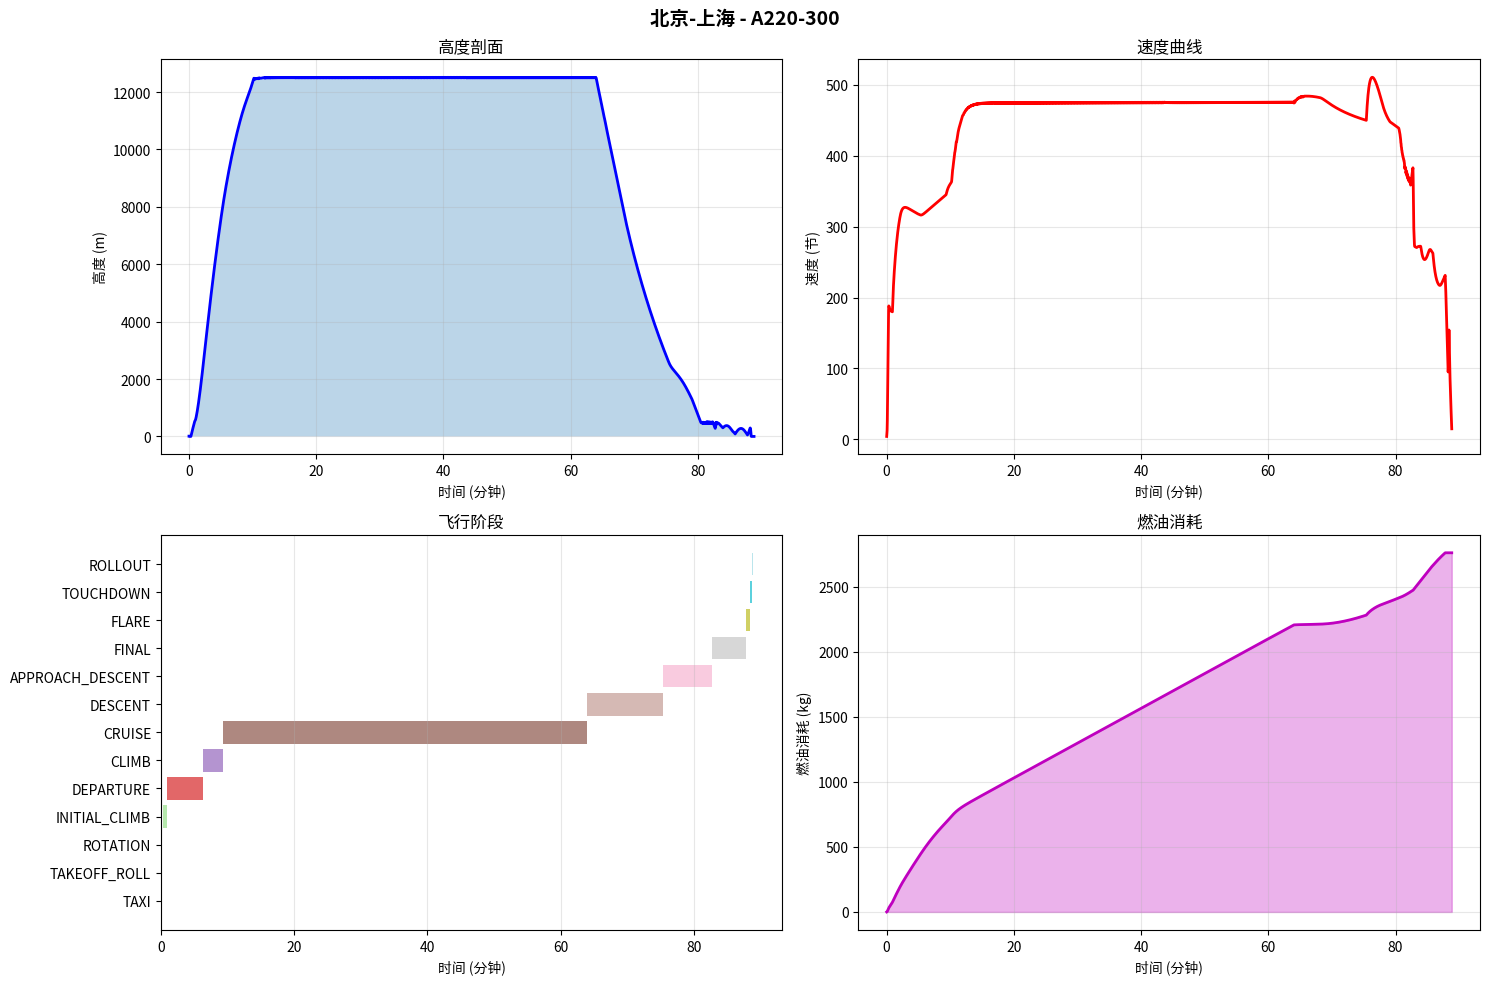


最大高度: 12513 m
最大速度: 510 节
总燃油: 2763 kg


In [20]:
# 创建综合可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 高度剖面
axes[0, 0].plot(trajectory_random['time']/60, trajectory_random['alt'], 'b-', linewidth=2)
axes[0, 0].fill_between(trajectory_random['time']/60, 0, trajectory_random['alt'], alpha=0.3)
axes[0, 0].set_xlabel('时间 (分钟)')
axes[0, 0].set_ylabel('高度 (m)')
axes[0, 0].set_title('高度剖面')
axes[0, 0].grid(True, alpha=0.3)

# 2. 速度曲线
axes[0, 1].plot(trajectory_random['time']/60, trajectory_random['tas']*1.944, 'r-', linewidth=2)
axes[0, 1].set_xlabel('时间 (分钟)')
axes[0, 1].set_ylabel('速度 (节)')
axes[0, 1].set_title('速度曲线')
axes[0, 1].grid(True, alpha=0.3)

# 3. 飞行阶段
phases = trajectory_random['flight_phase'].unique()
phase_colors = plt.cm.tab20(np.linspace(0, 1, len(phases)))
for i, phase in enumerate(phases):
    mask = trajectory_random['flight_phase'] == phase
    times = trajectory_random[mask]['time'] / 60
    if len(times) > 0:
        axes[1, 0].barh(phase, times.max() - times.min(), left=times.min(), 
                       color=phase_colors[i], alpha=0.7)
axes[1, 0].set_xlabel('时间 (分钟)')
axes[1, 0].set_title('飞行阶段')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. 燃油消耗
fuel_used = trajectory_random['fuel'].iloc[0] - trajectory_random['fuel']
axes[1, 1].plot(trajectory_random['time']/60, fuel_used, 'm-', linewidth=2)
axes[1, 1].fill_between(trajectory_random['time']/60, 0, fuel_used, alpha=0.3, color='m')
axes[1, 1].set_xlabel('时间 (分钟)')
axes[1, 1].set_ylabel('燃油消耗 (kg)')
axes[1, 1].set_title('燃油消耗')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f"{random_route['route_name']} - {random_aircraft}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n最大高度: {trajectory_random['alt'].max():.0f} m")
print(f"最大速度: {trajectory_random['tas'].max()*1.944:.0f} 节")
print(f"总燃油: {fuel_used.iloc[-1]:.0f} kg")


In [21]:
# 3D地图显示
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=trajectory_random['lon'],
    lat=trajectory_random['lat'],
    mode='markers+lines',
    line=dict(width=2, color='rgba(150,150,150,0.5)'),
    marker=dict(size=4, color=trajectory_random['alt'], colorscale='Viridis', showscale=True, colorbar=dict(title='高度(m)')),
    name='飞行轨迹',
    hovertemplate='时间: %{text}s<br>高度: %{marker.color:.0f}m<extra></extra>',
    text=trajectory_random['time']
))

fig.add_trace(go.Scattergeo(
    lon=[trajectory_random['lon'].iloc[0], trajectory_random['lon'].iloc[-1]],
    lat=[trajectory_random['lat'].iloc[0], trajectory_random['lat'].iloc[-1]],
    mode='markers+text',
    marker=dict(size=12, color=['green', 'red']),
    text=[random_route['origin_code'], random_route['dest_code']],
    textposition='top center',
    name='机场'
))

fig.update_geos(
    projection_type="natural earth",
    showland=True, landcolor='rgb(243, 243, 243)',
    coastlinecolor='rgb(204, 204, 204)',
)

fig.update_layout(
    title=f"随机轨迹地图: {random_route['route_name']} ({random_aircraft})",
    height=500
)

fig.show()


## 5. 场景2：指定航线和飞机生成轨迹

通过航线编号和飞机型号生成特定的飞行轨迹


In [22]:
# 显示可选航线（前20条）
print("可用航线列表（前20条）:")
print("="*80)
for idx in range(min(20, len(routes_df))):
    route = routes_df.iloc[idx]
    print(f"{idx:3d}. {route['route_name']:30s} ({route['origin_code']}-{route['dest_code']}) "
          f"{route['distance_km']:6.0f}km  [{route['category']}]")

print(f"\n可用飞机型号:")
print("="*80)
for i, ac in enumerate(aircraft_list):
    print(f"{i:2d}. {ac:12s}", end="  ")
    if (i + 1) % 5 == 0:
        print()


可用航线列表（前20条）:
  0. 北京-上海                          (PEK-PVG)   1099km  [中国]
  1. 北京-广州                          (PEK-CAN)   1881km  [中国]
  2. 北京-成都                          (PEK-CTU)   1557km  [中国]
  3. 北京-深圳                          (PEK-SZX)   1957km  [中国]
  4. 上海-广州                          (PVG-CAN)   1203km  [中国]
  5. 上海-成都                          (PVG-CTU)   1704km  [中国]
  6. 上海-深圳                          (PVG-SZX)   1233km  [中国]
  7. 上海-重庆                          (PVG-CKG)   1462km  [中国]
  8. 广州-成都                          (CAN-CTU)   1223km  [中国]
  9. 广州-重庆                          (CAN-CKG)    966km  [中国]
 10. 广州-杭州                          (CAN-HGH)   1038km  [中国]
 11. 广州-西安                          (CAN-XIY)   1306km  [中国]
 12. 北京-杭州                          (PEK-HGH)   1149km  [中国]
 13. 北京-西安                          (PEK-XIY)    935km  [中国]
 14. 北京-昆明                          (PEK-KMG)   2096km  [中国]
 15. 北京-重庆                          (PEK-CKG)   1465km  [中国]
 16. 北京-南京

In [23]:
# 指定航线编号和飞机型号（可根据需要修改）
route_index = 0  # 选择第一条航线
aircraft_index = 0  # 选择第一种飞机

selected_route = routes_df.iloc[route_index]
selected_aircraft = aircraft_list[aircraft_index]

print("\n" + "="*60)
print("场景2: 指定航线和飞机生成轨迹")
print("="*60)
print(f"选择的航线 [{route_index}]: {selected_route['route_name']}")
print(f"  起点: {selected_route['origin_code']}")
print(f"  终点: {selected_route['dest_code']}")
print(f"  距离: {selected_route['distance_km']:.0f} km")
print(f"\n选择的飞机 [{aircraft_index}]: {selected_aircraft}")

# 生成轨迹
trajectory_specified = generate_trajectory(selected_aircraft, selected_route)



场景2: 指定航线和飞机生成轨迹
选择的航线 [0]: 北京-上海
  起点: PEK
  终点: PVG
  距离: 1099 km

选择的飞机 [0]: A320-200

生成轨迹: 北京-上海 (A320-200)
  距离: 1099 km
  预计飞行时间: 82 分钟
  ✓ 无时间限制，飞行直到着陆完成
  进度: 10分钟, 高度=11835m, 速度=351节, 阶段=CRUISE, 距离=1009km
  进度: 20分钟, 高度=11890m, 速度=472节, 阶段=CRUISE, 距离=867km
  进度: 30分钟, 高度=11890m, 速度=473节, 阶段=CRUISE, 距离=721km
  进度: 40分钟, 高度=11890m, 速度=472节, 阶段=CRUISE, 距离=575km
  进度: 50分钟, 高度=11896m, 速度=472节, 阶段=CRUISE, 距离=430km
  进度: 60分钟, 高度=11896m, 速度=471节, 阶段=CRUISE, 距离=284km
  进度: 70分钟, 高度=6330m, 速度=472节, 阶段=DESCENT, 距离=138km
  进度: 80分钟, 高度=695m, 速度=440节, 阶段=APPROACH_DESCENT, 距离=6km
  ✓ 着陆完成!

✓ 轨迹生成完成!
  数据点数: 2613
  实际飞行时间: 87.1 分钟 (1.45 小时)
  最大高度: 11909 m (39070 ft)
  最大速度: 506 节
  燃油消耗: 3051 kg


### 指定轨迹详细分析


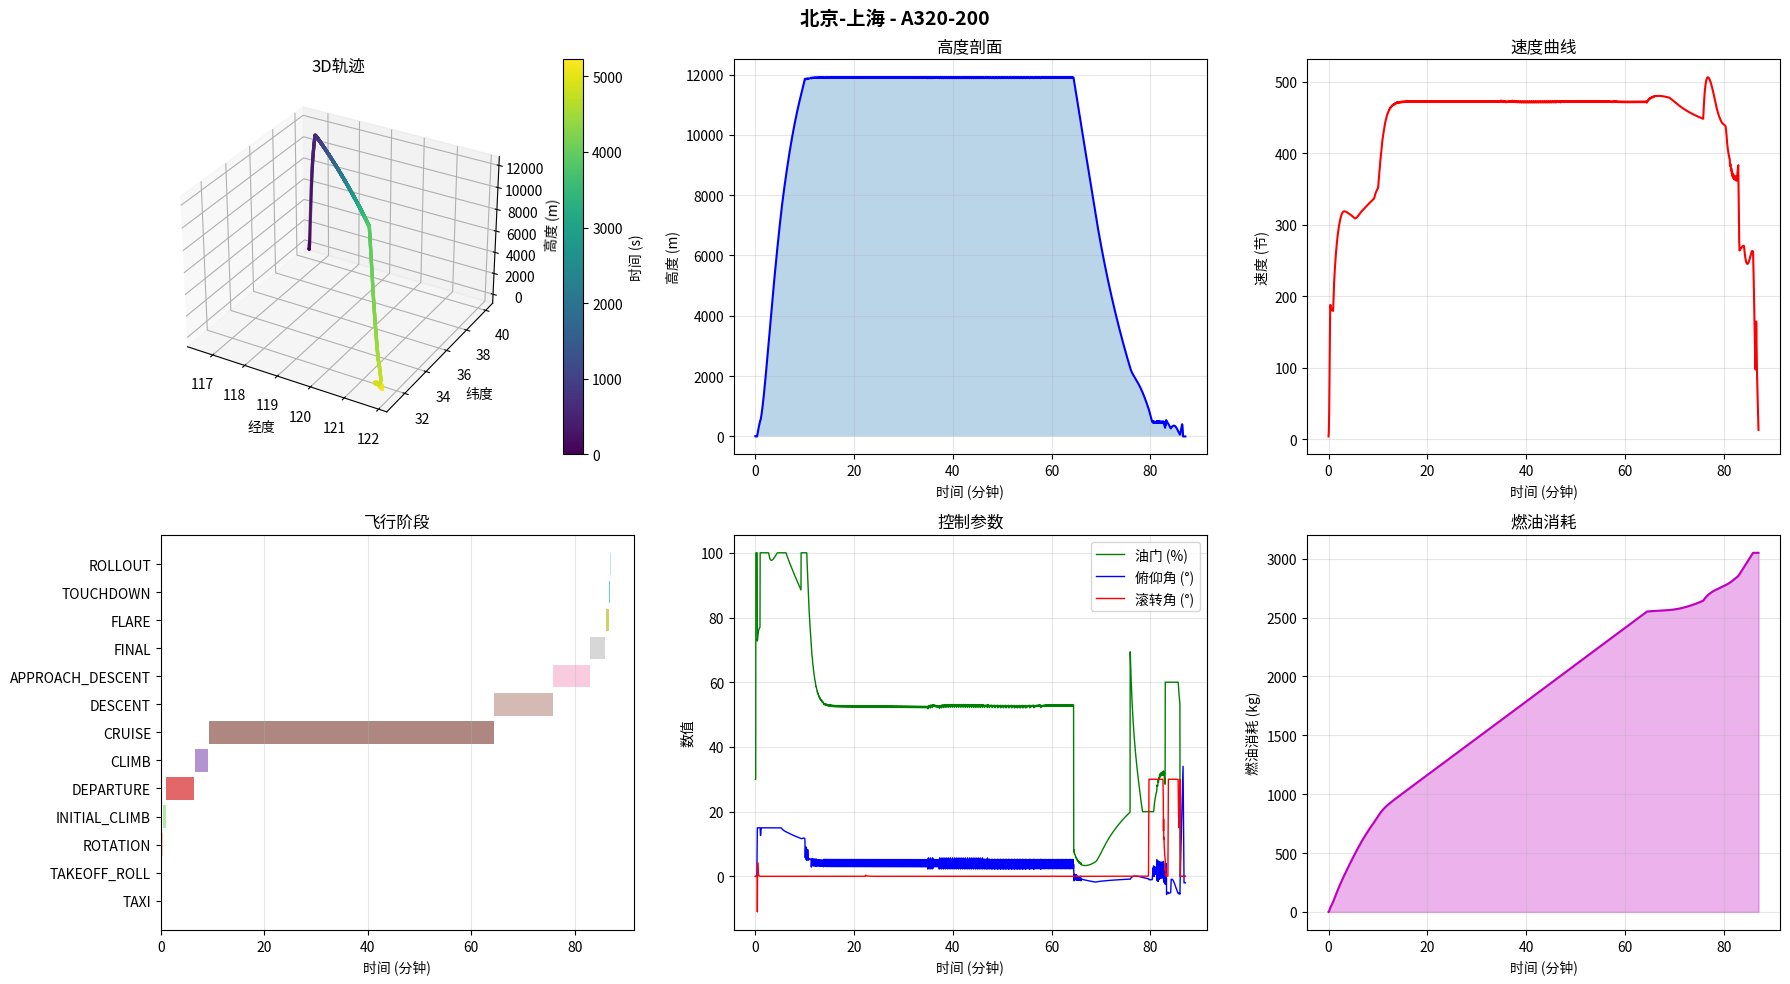


飞行统计:
  最大高度: 11909 m
  最大速度: 506 节
  总燃油: 3051 kg
  飞行时间: 87.1 分钟


In [24]:
# 创建3D轨迹可视化
fig = plt.figure(figsize=(18, 10))

# 1. 3D轨迹
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter = ax1.scatter(trajectory_specified['lon'], trajectory_specified['lat'], 
                     trajectory_specified['alt'],
                     c=trajectory_specified['time'], cmap='viridis', s=2)
ax1.set_xlabel('经度')
ax1.set_ylabel('纬度')
ax1.set_zlabel('高度 (m)')
ax1.set_title('3D轨迹')
plt.colorbar(scatter, ax=ax1, label='时间 (s)', pad=0.1)

# 2. 高度剖面
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(trajectory_specified['time']/60, trajectory_specified['alt'], 'b-', linewidth=1.5)
ax2.fill_between(trajectory_specified['time']/60, 0, trajectory_specified['alt'], alpha=0.3)
ax2.set_xlabel('时间 (分钟)')
ax2.set_ylabel('高度 (m)')
ax2.set_title('高度剖面')
ax2.grid(True, alpha=0.3)

# 3. 速度曲线
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(trajectory_specified['time']/60, trajectory_specified['tas']*1.944, 'r-', linewidth=1.5)
ax3.set_xlabel('时间 (分钟)')
ax3.set_ylabel('速度 (节)')
ax3.set_title('速度曲线')
ax3.grid(True, alpha=0.3)

# 4. 飞行阶段时间线
ax4 = fig.add_subplot(2, 3, 4)
phases = trajectory_specified['flight_phase'].unique()
phase_colors = plt.cm.tab20(np.linspace(0, 1, len(phases)))
for i, phase in enumerate(phases):
    mask = trajectory_specified['flight_phase'] == phase
    times = trajectory_specified[mask]['time'] / 60
    if len(times) > 0:
        ax4.barh(phase, times.max() - times.min(), left=times.min(), 
                color=phase_colors[i], alpha=0.7)
ax4.set_xlabel('时间 (分钟)')
ax4.set_title('飞行阶段')
ax4.grid(True, alpha=0.3, axis='x')

# 5. 控制参数
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(trajectory_specified['time']/60, trajectory_specified['throttle']*100, 
        'g-', linewidth=1, label='油门 (%)')
ax5.plot(trajectory_specified['time']/60, trajectory_specified['pitch'], 
        'b-', linewidth=1, label='俯仰角 (°)')
ax5.plot(trajectory_specified['time']/60, trajectory_specified['roll'], 
        'r-', linewidth=1, label='滚转角 (°)')
ax5.set_xlabel('时间 (分钟)')
ax5.set_ylabel('数值')
ax5.set_title('控制参数')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 燃油消耗
ax6 = fig.add_subplot(2, 3, 6)
fuel_used = trajectory_specified['fuel'].iloc[0] - trajectory_specified['fuel']
ax6.plot(trajectory_specified['time']/60, fuel_used, 'm-', linewidth=1.5)
ax6.fill_between(trajectory_specified['time']/60, 0, fuel_used, alpha=0.3, color='m')
ax6.set_xlabel('时间 (分钟)')
ax6.set_ylabel('燃油消耗 (kg)')
ax6.set_title('燃油消耗')
ax6.grid(True, alpha=0.3)

plt.suptitle(f"{selected_route['route_name']} - {selected_aircraft}", 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 统计信息
print("\n飞行统计:")
print(f"  最大高度: {trajectory_specified['alt'].max():.0f} m")
print(f"  最大速度: {trajectory_specified['tas'].max()*1.944:.0f} 节")
print(f"  总燃油: {fuel_used.iloc[-1]:.0f} kg")
print(f"  飞行时间: {trajectory_specified['time'].iloc[-1]/60:.1f} 分钟")


In [25]:
# 地图显示
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=trajectory_specified['lon'],
    lat=trajectory_specified['lat'],
    mode='markers+lines',
    line=dict(width=2, color='rgba(150,150,150,0.5)'),
    marker=dict(size=4, color=trajectory_specified['alt'], colorscale='Jet', showscale=True, colorbar=dict(title='高度(m)')),
    name='飞行轨迹',
    hovertemplate='时间: %{text}s<br>高度: %{marker.color:.0f}m<extra></extra>',
    text=trajectory_specified['time']
))

fig.add_trace(go.Scattergeo(
    lon=[trajectory_specified['lon'].iloc[0], trajectory_specified['lon'].iloc[-1]],
    lat=[trajectory_specified['lat'].iloc[0], trajectory_specified['lat'].iloc[-1]],
    mode='markers+text',
    marker=dict(size=15, color=['green', 'red'], symbol=['circle', 'square']),
    text=[selected_route['origin_code'], selected_route['dest_code']],
    textposition='top center',
    textfont=dict(size=14, color='black'),
    name='机场'
))

fig.update_geos(
    projection_type="natural earth",
    showland=True, landcolor='rgb(243, 243, 243)',
    coastlinecolor='rgb(204, 204, 204)',
    showocean=True, oceancolor='rgb(230, 245, 255)',
)

fig.update_layout(
    title=f"指定轨迹地图: {selected_route['route_name']} ({selected_aircraft})",
    height=500
)

fig.show()


## 6. 总结

本notebook完整展示了飞行系统的集成测试，包括：

### ✅ 完成的功能
1. **航线网络可视化** - 全球300条航线的交互式地图
2. **随机轨迹生成** - 自动选择航线和飞机生成真实轨迹
3. **指定轨迹生成** - 通过索引选择特定航线和飞机
4. **详细可视化** - 3D轨迹、高度剖面、速度、燃油等多维度分析

### 🎯 系统特性
- **20种真实飞机** - 详细的空气动力学和性能参数
- **300条全球航线** - 包含2-10个真实航路点
- **17个飞行阶段** - 使用专业民航术语
- **高保真模型** - 六自由度飞行动力学
- **标准程序** - 包含五边进近等标准民航程序

### 📊 输出数据
每条轨迹包含丰富的状态信息：
- 位置、速度、姿态
- 飞行阶段标识
- 燃油消耗
- 控制参数

### 🚀 使用方法
- **随机生成**: 运行场景1，自动选择航线和飞机
- **指定生成**: 修改场景2中的`route_index`和`aircraft_index`
- **数据导出**: 轨迹数据可保存为CSV用于进一步分析

### 📝 说明
- 为了加快仿真速度，示例中选择了短程航线（<1500km）
- 可通过修改`max_time`参数延长或缩短仿真时间
- 所有可视化都是交互式的，可以放大、缩小、平移
